In [1]:
%%js
MathJax.Hub.Config({
  TeX: { 
    equationNumbers: { autoNumber: "AMS" } 
    }
});

<IPython.core.display.Javascript object>

# Моделирование

In [2]:
from pylab import *
rcParams['figure.figsize'] = [7, 6]
rcParams['axes.labelsize'] = 20
from IPython.display import display, Math,Latex,HTML
import pandas as pd
import time
from matplotlib import animation
%load_ext skip

$\renewcommand{\phi}{\varphi}$
Для моделирования случайной поверхности $\Sigma(\vec{r},t)$ используется ее представление в виде суперпозиции плоских волн (гармоник) с различными частотами $\omega_n$ и случайными фазами $\Psi_{nm}$, бегущих под разными азимутальными углами $\phi_m$:
$$\begin{equation*}
    \Sigma(\vec{r},t)=\sum\limits_{n=1}^N\sum_{m=1}^M A_n
    cos(\omega_nt+\vec{k_n}\vec{r}+\Psi_{nm})\cdot\Phi_{nm}
    (\omega_n,\phi_m)
    \label{eq:1}
\end{equation*}$$
Далее будут приведены основные соотношения, необходимые для этого уравнения

In [3]:
def find_decision(omega):
    P = 9.8*1000.0/0.074;
    Q = -1000.0*omega**2/0.074;
    x1= -Q/2.0 + sqrt( (Q/2)**2 + (P/3)**3 )
    x2= -Q/2.0 - sqrt( (Q/2)**2 + (P/3)**3 )
    k=x1**(1/3)-(-x2)**(1/3)
    return k

def det(k): 
#    Функция возвращает детерминант при переходе от частоты к 
#волновым числам по полному дисперсионному
    det=(9.8+3*k**2*0.074/1000)/(2*sqrt(9.8*k+k**3*0.074/1000) )
    return det

In [4]:
global g
g=9.81
def k_max(omega_max):
    k_max=omega_max**2/g
    return k_max

def omega_k(k): # Пересчет волнового числа в частоту по полному дисперсионному
    omega_k=(g*k+0.074*k**3/1000)**(1/2) #Сложное дисперсионное
    return omega_k  

def full_spectrum(k,x=20170, long_calculate=True):
    def JONSWAP(k):
        if k<=k_m:
            sigma=0.07
        else:
            sigma=0.09
        Sw=(
            Alpha(x)/2*k**(-3)*exp(-1.25*(k_m/k)**2 )*
            Gamma(x)**(exp(- ( sqrt(k/k_m)-1)**2 / (2*sigma**2) ))
           )
        return Sw

    def Gamma(x):
        if x>=20170:
            return 1
        gamma=(
               +5.253660929
               +0.000107622*x
               -0.03778776*sqrt(x)
               -162.9834653/sqrt(x)
               +253251.456472*x**(-3/2)
              )
        return gamma

    def Alpha(x):
        if x>=20170:
            return 0.0081
        alpha=array([],dtype='float64')
        alpha=[( 
               +0.0311937
               -0.00232774*log(x)
               -8367.8678786/x**2
               +4.5114599e+300*exp(-x)*1e+300*1e+17
    #            +4.5114599e+17*exp(-x)
              )]
        return alpha[0]

    def Omega(x): #Вычисление безразмерной частоты по безразмерному разгону
        if x>=20170:
            return 0.835
        omega_tilde=(0.61826357843576103 
                     + 3.52883010586243843e-06*x
                     - 0.00197508032233982112*sqrt(x)
                     + 62.5540113059129759/sqrt(x)
                     - 290.214120684236224/x
        )
        return omega_tilde

    def spectrum1(k):


        omega0=omega_k(limit_k[0])
        beta0= JONSWAP(limit_k[0])*omega0**4/det(limit_k[0])

        omega0=omega_k(k)

        return beta0/omega0**4*det(k)

    def spectrum2(k):


        omega0=omega_k(limit_k[1])
        beta0= spectrum1(limit_k[1])*omega0**5/det(limit_k[1])

        omega0=omega_k(k)

        return beta0/omega0**5*det(k)

    def spectrum3(k):


        omega0=omega_k(limit_k[2])
        beta0= spectrum2(limit_k[2])*omega0**2.7/det(limit_k[2])

        omega0=omega_k(k)

        return beta0/omega0**2.7*det(k)

    def spectrum4(k):


        omega0=omega_k(limit_k[3])
        beta0= spectrum3(limit_k[3])*omega0**5/det(limit_k[3])

        omega0=omega_k(k)

        return beta0*det(k)/omega0**5
    
#     def spectrum(k):
#         omega0=[omega_k(limit_k[i]) for i in range(4)]
#         p=[4,5,2.7,5]
#         S=[0,0,0,0]
#         S[0]=lambda a: JONSWAP(limit_k[0]) * (omega0[0]/omega_k(a))**p[0] * det(a)/det(limit_k[0])
#         S[1]=lambda a: S[0](limit_k[1])    * (omega0[1]/omega_k(a))**p[1] * det(a)/det(limit_k[1])
#         S[2]=lambda a: S[1](limit_k[2])    * (omega0[2]/omega_k(a))**p[2] * det(a)/det(limit_k[2])
#         S[3]=lambda a: S[2](limit_k[3])    * (omega0[3]/omega_k(a))**p[3] * det(a)/det(limit_k[3])
#         spectrum=zeros((len(k),4))
#         for j in range(len(k)):
#             for i in range(4):
#                 spectrum[j][i]=S[i](k[j])
#         return spectrum
    
    gamma,alpha,omega_m=Gamma(x),Alpha(x),Omega(x)
    
    try:
        full_spectrum=zeros(len(k))
    except:
        full_spectrum=[0]
        k=[k]
    if long_calculate==False:
        k=logspace(log10(k[0]),log10(k[-1]),1000)
        
    omega=omega_m*g/U10
    global k_m
    k_m=k_max(omega)
    limit_1= 1.2   #{ НАЧИНАЕТСЯ  - 1/(W**4) }
    limit_2=(
             +0.371347584096022408 
             + 0.290241610467870486*U10
             + 0.290178032985796564/U10
            )
    limit_3= 270.0 #{ НАЧИНАЕТСЯ 1/W**2.7 }
    limit_4= 1020.0 #{ НАЧИНАЕТСЯ 1/W*5 }

    limit_k=np.zeros(4)
    limit_k[0]=find_decision(limit_1*omega)
    limit_k[1]=find_decision(limit_2*omega)
    limit_k[2]=limit_3
    limit_k[3]=limit_4

    for i in range(len(k)):
        if k[i] <= limit_k[0]:
            full_spectrum[i] =  JONSWAP(k[i])
        elif k[i] <= limit_k[1]:
            full_spectrum[i] = spectrum1(k[i])
        elif k[i] <= limit_k[2]:
            full_spectrum[i] = spectrum2(k[i])
        elif k[i] <= limit_k[3]:
            full_spectrum[i] = spectrum3(k[i])
        else:
            full_spectrum[i] = spectrum4(k[i])

#     S=spectrum(k)
#     for i in range(len(k)):
#         if k[i] <= limit_k[0]:
#             full_spectrum[i] =  JONSWAP(k[i])
#         elif k[i] <= limit_k[1]:
#             full_spectrum[i] = S[i][0]
#         elif k[i] <= limit_k[2]:
#             full_spectrum[i] = S[i][1]
#         elif k[i] <= limit_k[3]:
#             full_spectrum[i] = S[i][2]
#         else:
#             full_spectrum[i] = S[i][3]

    return full_spectrum

Время выполнения --- 15.854667663574219 c


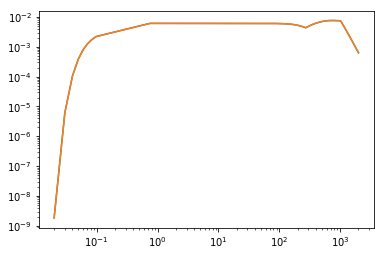

In [5]:
U10=10
x=20170
name='SEAWVS_1.dat'
data=pd.read_csv(name,sep='\s+')
KT=array(data['KT'])
OUR=array(data['OUR'])
loglog(KT,OUR)
k=linspace(KT[0],KT[-1],len(KT))
# k=logspace(log10(k[0]),log10(k[-1]),10000)
start_time = time.time()
S=full_spectrum(k,x=20170)
print("Время выполнения --- %s c" % (time.time() - start_time))
loglog(k,k**3*S)

## Угловое распределение
Угловое распределение $\Phi_{\omega}$ описывается следующей формулой:
$$\Phi_{\omega}=A\cdot\frac{2}{\exp(2B\phi)+\exp(-2B\phi)}=\frac{A}{\cosh(2B\phi)},\, -\pi\leq\phi\leq\pi$$
Где $B=10^b$, а b описывается следующей формулой:
$$b=-0.28+0.65\exp\left\{-0.75\log(\frac{k}{k_m})\right\}+0.01\exp\left\{0.2+0.7\lg(\frac{k}{k_m})\right\}$$

In [6]:
def B(k):
    def b(k):
        b=(
            -0.28+0.65*exp(-0.75*log(k/k_m))
            +0.01*exp(-0.2+0.7*log10(k/k_m))  
          )          
        return b
    B=10**b(k)
    return B

def Normalization(B):
    Normalization=B/arctan(sinh(2*pi*B))
    return Normalization

def Phi(k,phi):
    try:
        Phi=zeros((len(k),len(phi)))
        for i in range(len(k)):
            B0=B(k[i])
            A0=Normalization(B0)
            Phi[i]=A0/cosh(2*B0*phi)
    except:
        B0=B(k)
        A0=Normalization(B0)
        Phi=A0/cosh(2*B0*phi)
    return Phi

# Для проверки

Все равно придётся считать

 
 При увеличении числа гармоник происходит
улучшение качества моделируемой поверхности, но возрастает время
счета. Поэтому, как и в случае с угловым распределением, здесь также
было выбрано компромиссное решение. Критерием была выбрана 
    близость корреляционных функций высот $ K_{\sum} (\rho)$ и наклонов вычисленных по исходному спектру $S_{\sum}(\omega)$ и по реализации поверхности $\Sigma (\vec r, t)$:
 
 $$K_{\sum}(\rho)=\int\limits_{(k)}S_{\sum}(k)\cos(k\rho)dk$$
 
 $$K_{\sum}^M(\rho)=\sum\limits_{n=1}^N \frac{A^2_n}{2}\cos(k\rho)$$
  
 $$K_{\sum\theta}(\rho)=\int\limits_{(k)}k^2S_{\sum}(k)\cos(k\rho)dk$$
   
  $$K_{\sum\theta}^M(\rho)=\sum\limits_{n=1}^N \frac{A^2_n k^2}{2}\cos(k\rho)$$

0.0
2000.980000000002


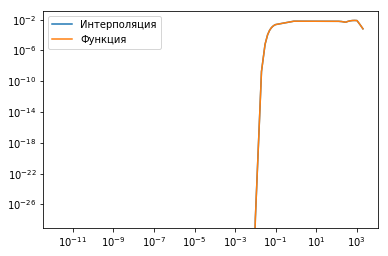

In [7]:
from scipy import interpolate
k=arange(KT[0]*10**(-10),KT[-1]+1,0.01)
S=full_spectrum(k)
full_spectrum=interpolate.interp1d(k,S)
loglog(k,k**3*full_spectrum(k),label='Интерполяция')
loglog(k,k**3*S,label='Функция')
print(norm(S-full_spectrum(k)))
print(k[-1])
legend()
k_edge=111.8-17.937*U10+3.095*U10**2+1.2656*U10**2*log(U10)+0.3141*U10*(2.5)



In [8]:
def angle(k,phi):
    angle=sqrt( 2*pi/100 * Phi(k,phi) )
    return angle

def amplitude(k,N):
    # k-- выбранный диапазон волновых чисел
    # N-- количество моделируемых гармоник
    N+=1
    k=logspace(log10(KT[0]),log10(KT[-1]),N)
    S=full_spectrum(k)
    dk=zeros(N)
    dS=zeros(N)
#     dk[0]=(k[1]-k[0])
    for i in range(1,N):
        dk[i]=(k[i]-k[i-1])
        dS[i]=S[i]
    amplitude=sqrt(2*dk * dS)
    return amplitude[1:]
# def amplitude_new(k,N):
#     # k-- выбранный диапазон волновых чисел
#     # N-- количество моделируемых гармоник
#     hk=KT[-1]/N
#     print(hk)
#     dk=arange(hk,(N)*hk,hk)
# #     print(dk)
#     loglog(dk,dk**3*full_spectrum(dk))
#     print(len(dk))
#     b=zeros(N)
#     for i in range(1,N):
#         k=arange((i)*hk,(i+1)*hk,hk/10000)
# #         print(k[-1])
#         b[i]=trapz(full_spectrum(k)*k**3,k)
# #     print(b[1:])
#     return b[1:],dk
# # N=10000
# # k=logspace(log10(KT[0]),log10(KT[-1]),N)
# # A=amplitude(k,N)
# # loglog(k,A)
# # # plot(amplitude(k,N))
# N=200
# k=logspace(log10(KT[0]),log10(KT[-1]),N)
# A,k=amplitude_new(k,N)
# # loglog(k,A)
# # from scipy import signal
# # imp = signal.unit_impulse(1000, 'mid')


0.33993302858546487 0.34012882374265346


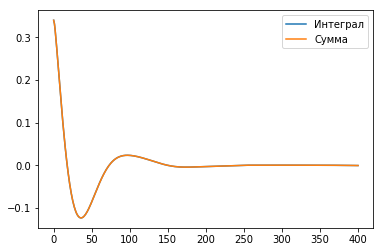

In [9]:
# print avada kedavra
from scipy.integrate import simps
from numpy.linalg import norm
U10=10

def correlation_height(k,rho):
    S=full_spectrum(k)
    integral=zeros(len(rho))
    for i in range(len(rho)):
        integral[i]=trapz(S*cos(k*rho[i]),k)
    return integral

def correlation_height_sum(k,rho,N=1000):
    f=0
    A=amplitude(k,N)
    k=logspace(log10(KT[0]),log10(KT[-1]),N)
    f=zeros(len(rho))
    for j in range(len(rho)):
            f[j]=sum( A**2/2*cos(k*rho[j]) )
    return f

    
k=logspace(log10(KT[0]),log10(KT[-1]),10000)
rho=linspace(0,400,400)
y=zeros(len(rho))
N=1000
y=correlation_height_sum(k,rho, N=10000)
y1=correlation_height(k,rho)
print(y[0],y1[0])
plot(rho,y1,label='Интеграл')
plot(rho,y,label='Сумма')
legend()



Дисперсия наклонов sigma= 0.3401329982924888
sigma/N= 0.0017006649914624438
error= 1.3372190502496813e-09
error= 1.9391232099962123e-17
error= 2.2350554942755622e-17
error= 2.388564508315136e-17
error= 2.1864742750332993e-17
error= 6.839830430735966e-09
error= 1.942216404587826e-17
error= 2.1426610602777136e-17
error= 2.3550992945108047e-17
error= 2.5801560856876037e-17
error= 2.818487276091312e-17
error= 3.07078106010991e-17
error= 3.337759543417873e-17
error= 3.6201803764821356e-17
error= 1.9210400370952233e-17
error= 1.4544904593353238e-08
error= 2.0425914707603937e-17
error= 2.0881631705820963e-17
error= 2.1347736318460417e-17
error= 2.182446798871177e-17
error= 2.2312071710761297e-17
error= 2.2810798158857626e-17
error= 2.3320903819365004e-17
error= 2.3842651125911717e-17
error= 2.4376308597673964e-17
error= 2.4922150980877924e-17
error= 2.548045939360529e-17
error= 2.6051521473961413e-17
error= 2.6635631531701808e-17
error= 2.7233090703380812e-17
error= 2.784420711112304e-17
erro

c:\program files\python37\lib\site-packages\scipy\integrate\quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


error= 1.5668523193721262e-08
error= 2.378865772219673e-09
error= 0.0
error= 0.0
error= 0.0
error= 0.0
error= 0.0
error= 0.0
error= 0.0
error= 0.0
error= 0.0
error= 0.0
error= 0.0
error= 0.0
error= 0.0
error= 0.0
error= 0.0
error= 0.0
error= 0.0
error= 0.0
error= 0.0
error= 0.0
error= 0.0
error= 0.0
error= 0.0
error= 0.0
error= 0.0
error= 0.0
error= 0.0
error= 0.0
error= 0.0
error= 0.0
error= 0.0
error= 0.0
error= 0.0
error= 0.0
error= 0.0
error= 0.0
error= 0.0
error= 0.0
error= 0.0
error= 0.0
error= 0.0
error= 0.0
error= 0.0
error= 0.0
error= 0.0
error= 0.0
error= 0.0
error= 0.0
error= 0.0
error= 0.0
error= 0.0
error= 0.0
error= 0.0
error= 0.0
error= 0.0
Сумма интегралов между узлами (поверка)= 0.3401287430434756
Остаток= 1.8819961321042634e-12
[3.17124729e-02 3.43767748e-02 3.64158241e-02 3.81338061e-02
 3.94752749e-02 4.08639337e-02 4.18167404e-02 4.27917633e-02
 4.37895204e-02 4.48105417e-02 4.58553697e-02 4.69245596e-02
 4.80186793e-02 4.91383101e-02 4.97078775e-02 5.02840468e-02


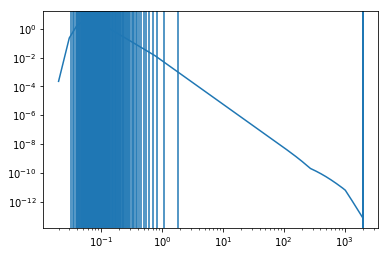

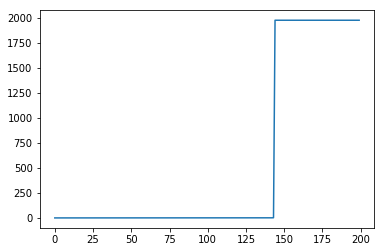

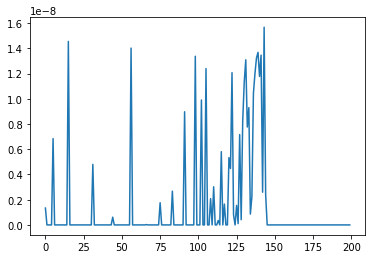

In [10]:
# Функция выбирает узлы по условию равенства интегралов между ними
from scipy  import integrate
def interspace(k,N):
    y=lambda k: full_spectrum(k)
    sigma=trapz(y(k),k)
    print('Дисперсия наклонов sigma=',sigma)
    b0=sigma/(N)
    print('sigma/N=', b0)
    dk=zeros(N)
    k_new=k
    I=zeros(N)
    err=zeros(N)
    eps=0.01   
    for i in range(N):
        integral=0
        n=1
        while integral<b0 and n< len(k):
#             print('k',k_new)
            k_new=k[0:n]
#             integral=trapz(y(k_new),k_new)
            integral,error=integrate.quad(y,k_new[0],k_new[-1],
            limit=100,epsabs=1.49e-8, epsrel=1.49e-8)
            n+=1
        I[i]=integral
        err[i]=error
#         print('I=',I[i])
        print('error=',error)
        dk[i]=k_new[-1]
#         print('dk=',dk[i])
        a=where(k==dk[i])[0][0]
#         print('a',a)
        k=k[a:]
        
    a=where(k==dk[-1])[0][0]
    k_new=k[a:]
    print('Сумма интегралов между узлами (поверка)=', 
          sum(I)         )
    print('Остаток=',trapz(y(k_new),k_new))
    return dk,b0,err
N=2
figure()
k=logspace(log10(KT[0]),log10(KT[-1]),10**3)
j,b0,err=interspace(k,200)
rho=linspace(0,10,100)
k=arange(k[0],k[-1],k[0]/2)
S=lambda k: full_spectrum(k)
y=zeros(len(rho))
loglog(k,S(k))
for i in j:
    axvline(x=i)
figure()
plot(j)
print(j)
figure()
plot(err)

In [11]:
k=linspace(j[1],j[2],10**3)
trapz(full_spectrum(k),k)

0.002013159018234361

0.02848586773795883
0.033625771695051584
0.038570382347106726
0.04195951225959569
0.04177563397164391
0.046824008461408564
0.04193554479306324
0.045073051016841156
0.048356175714122394
0.051793798292516686
0.055394993428348416
0.05916908266519695
0.06312567912294535
0.06727472738711217
0.049853730976493996
0.05137597633903012
0.05260451092232942
0.05380460571408354
0.055032362779286546
0.05628842338104061
0.057573443691483775
0.058888095138925796
0.06023306476304988
0.06160905557841694
0.06301678694642508
0.0644569949559337
0.0659304328127675
0.06743787123828443
0.06898009887724117
0.07055792271515123
0.07217216850538108
0.07371590715791054
0.07494581966756518
0.0761690708750183
0.07741111390186523
0.07867219799325267
0.07995257425381189
0.08125249559821932
0.08257221669806061
0.08391199392480315
0.08527208528871866
0.0866527503735799
0.08805425026687495
0.0894768474854382
0.09090753590881909
0.09214081189135657
0.093306133447767
0.09447670305741465
0.0956520493835298
0.096831668776680

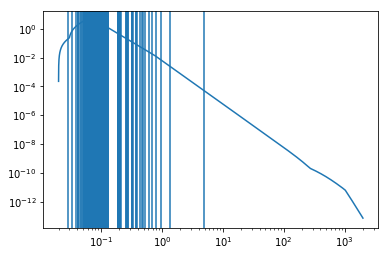

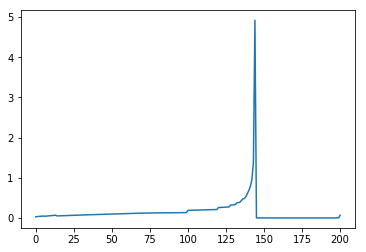

In [12]:
def nodes(ki,b0):
    y=lambda k: k**2*full_spectrum(k)
    nodes=zeros(len(ki))
    for i in range(1,len(ki)):
        k=linspace(ki[i-1],ki[i],10**3)
        A=(trapz(y(k),k))
        B=(sqrt(A/b0))
        nodes[i-1]=B
        print(B)
    return nodes[:-1]

ki=hstack(([KT[0]],j,KT[-1]))
node=nodes(ki,b0)

k=logspace(log10(KT[0]),log10(KT[-1]),10**6)
# k=arange(k[0],k[-1],k[0]/2)
S=lambda k: full_spectrum(k)
y=zeros(len(rho))
loglog(k,S(k))
for i in node:
    axvline(x=i)
figure()
plot(node)
print(node)

In [13]:
# print avada kedavra
k_edge=111.8-17.937*U10+3.095*U10**2+1.2656*U10**2*log(U10)+0.3141*U10*(2.5)

def amplitude(k,N):
    # k-- выбранный диапазон волновых чисел
    # N-- количество моделируемых гармоник
    N=len(k)
    S=full_spectrum(k)
    dk=zeros(N)
    dS=zeros(N)
    for i in range(1,N):
        dk[i]=(k[i]-k[i-1])
        dS[i]=S[i]
    amplitude=sqrt(2*dk * dS)
    return amplitude


def correlation_angles(k,rho):
    integral=zeros(len(rho))
    S=k**2*full_spectrum(k)
    y=lambda k,rho: S*cos(k*rho)
    for i in range(len(rho)):
        integral[i]=trapz(y(k,rho[i]),x=k)
    return integral
    
def correlation_angles_sum(k,rho):
    f=0
    A=amplitude(k,N)
    f=zeros(len(rho))
    for j in range(len(rho)):
            f[j]=sum( k**2*A**2/2*cos(k*rho[j]) )
    return f
print(k_edge)
k=node
rho=linspace(0,400,400)
y=zeros(len(rho))
y=correlation_angles_sum(k,rho)
k=logspace(log10(KT[0]),log10(KT[-1]),10**3)
y1=correlation_angles(k,rho)
plot(rho,y,label='Сумма')
plot(rho,y1,label='Интеграл')
legend()
print(y[0],y1[0])


541.1976693693264


ValueError: A value in x_new is below the interpolation range.

In [ ]:
y=lambda k: k**2*full_spectrum(k)
k=logspace(log10(KT[0]),log10(KT[-1]),10**2)
loglog(k,y(k))


In [ ]:
rho=linspace(0,8,400)
plot(rho,correlation_angles(j,rho))
print avada kedavra

In [ ]:
k=logspace(log10(KT[0]),log10(KT[-1]),10**4)
# k=linspace(KT[0],KT[-1],10**4)
k=arange(KT[0],KT[-1]+KT[0]/2,KT[0]/2)
A=[]
for i in range(len(k)):
    if k[i]<KT[1]*1.001 and k[i]>KT[1]*0.999:
        A.append(k[i])
where(k==A)

In [ ]:
rho=linspace(0,8,100)
y1=correlation_angles(j,rho)
plot(rho,y1)

Встала задача нахождения интеграла аналитически. Для этого изначально ещё нужно выбрать оптимальное распеределение волновых чисел.

In [ ]:
def find_garmonics(k,rho):
    N=100
    k=logspace(log10(KT[0]),log10(KT[-1]),10000)
    S=correlation_height_sum(k,rho,N)
    I=correlation_height(k,rho)
    while abs(norm(S-I))>0.01:
        N*=2
        S=correlation_height_sum(k,rho,N)
    print('Количество гармоник для высот N=',N)
    
    k=logspace(log10(KT[0]),log10(KT[-1]),10**5)
    S=correlation_angles_sum(k,rho,N)
    I=correlation_angles(k,rho)
    while abs(norm(S-I))>0.01:
        N+=100
        S=correlation_angles_sum(k,rho,N)
    print('Количество гармоник для наклонов N=',N)
    return N
k=logspace(log10(KT[0]),log10(KT[-1]),10**5)
rho=linspace(0,400,400)
find_garmonics(k,rho)

In [ ]:
from numpy import random
def model(k,phi,N):
    U10=10
    rho=linspace(0,400,400)
    A=amplitude(k,N)
    F=angle(k,phi)
    psi=array([
    [ random.uniform(0,2*pi) for j in range(100)] 
      for i in range(N)              ]) 
    
    def water(r,phi,t=0):
        model=0
        for n in range(N):
            for m in range(100):
                model+=A[n]*cos(
                    k[n]*(r[0]*cos(phi[m])+r[1]*sin(phi[m]))+psi[n][m]
                )*F[n][m]
        return model
    
    return water

k=logspace(log10(KT[0]),log10(KT[-1]),10**5)
rho=linspace(0,400,400)
# N=find_garmonics(k,rho)
N=4500
k=logspace(log10(KT[0]),log10(KT[-1]),N)
phi=linspace(-pi,pi,100)

sigma=model(k,phi,N)
x=linspace(0,400,400)
y=linspace(0,400,400)
water=sigma([x,y],phi)
start_time = time.time()
plot(x,water)
print("Время выполнения --- %s c" % (time.time() - start_time))

dispersion=std(water)
# mn=mean(sigma(x))
print('Дисперсия =',dispersion)
# print('Среднее=',mn)
print(correlation_height(k,[0]))

In [ ]:
# # %matplotlib inline
# x=linspace(0,400,40)
# y=linspace(0,400,40)
# rcParams['figure.figsize'] = [7, 6]
# rcParams['axes.labelsize'] = 20
# x, y = np.meshgrid(x, y)
# z=sigma([x,y],phi)
# contourf(z,100,cmap=cm.winter)
# colorbar()
# ylabel(r'Y',fontsize=16)
# xlabel(r'X',fontsize=16)
# savefig('water.png',pdi=1500)
# show()